In [2]:
using Revise
using NMRlab

In [3]:
GISSMO.search("Gluconic acid")

2-element Vector{Any}:
 Dict{String, Any}("name" => "Gluconic acid", "id" => "bmse000084")
 Dict{String, Any}("name" => "Glutaconic-acid", "id" => "bmse000435")

In [4]:
n,H=GISSMO.Hamiltonian("bmse000084") ;

In [5]:
using LinearAlgebra
using SparseArrays

δt = π/2 / opnorm(H,Inf)
P=SpinSim.expm(-im*δt*(H))
rho0=sum(SpinSim.SpinOp(n,SpinSim.Sx,k) for k=1:n)
Fp=sum(SpinSim.SpinOp(n,SpinSim.Sp,k) for k=1:n)
fid = ComplexF64[]
sizehint!(fid,2<<14)
ρ = rho0
for k=1:2<<14
    push!(fid, tr(ρ*Fp)*exp(-2*π*k*δt))
    ρ = P*ρ*P'
    droptol!(ρ,10*eps(Float64))
end

In [6]:
using FFTW

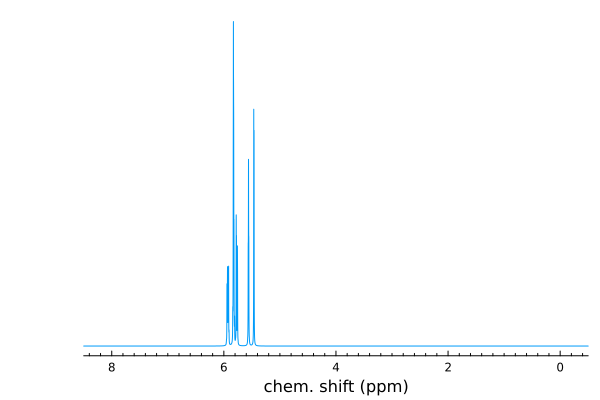

In [7]:
using Plots
Plots.plot(range(-0.5/δt,stop=0.5/δt,length=length(fid))/600.0.+4.78, 
            real.(fftshift(fft(fid))),
            xaxis=:flip,
            minorticks=10,
            xlabel="chem. shift (ppm)",
            xlims=[-0.5,8.5],
            yaxis=false,
            grid=false,
            legend=false,
            fmt=:png,
)

## can we do a simulation in the Liouvillian space?

In [8]:
function vec(A::AbstractSparseMatrix)
    n,m=size(A)
    return sparsevec(reshape(A,n*m,1))
end

rho0 = sum(SpinSim.SpinOp(n,SpinSim.Sx,k) for k=1:n) |> vec
l,m=size(H)
HT=spzeros(l,l)
transpose!(HT,H)
Hsup = SpinSim.Kron(sparse(I,l,l),H) - SpinSim.Kron(HT,sparse(I,l,l))
Rsup = sparse(I,l*l,l*l)*0.5*π
Psup = SpinSim.expm(-im*δt*(Hsup-im*Rsup));

In [9]:
fidl = ComplexF64[]
sizehint!(fidl,2<<14)
Fpm=vec(Fp)
ρ = rho0
for k=1:2<<14
    push!(fidl, sum(conj.(ρ).*Fpm))
    ρ = Psup*ρ
    droptol!(ρ,10*eps(Float64))
end

In [19]:
Plots.plot(range(-0.5/δt,stop=0.5/δt,length=length(fid))/600.0.+4.78, 
            real.(fftshift(fft(fidl))),
            xaxis=:flip,
            minorticks=10,
            xlabel="chem. shift (ppm)",
            xlims=[5,6.5],
            yaxis=false,
            grid=false,
            legend=false,
            fmt=:png,dpi=300,
)
savefig("Gluconate-spect.png")

"/home/mu3q/Source/NMRlab/src/Gluconate-spect.png"

In [20]:
a=Plots.spy(abs.(Psup),title="nnz=$(nnz(Psup))",legend=false,fmt=:png,dpi=300);
savefig(a,"Psup-spy.png")

a=Plots.spy(abs.(Hsup),title="nnz=$(nnz(Hsup))",legend=false,fmt=:png,dpi=300);
savefig(a,"Hsup-spy.png")

"/home/mu3q/Source/NMRlab/src/Hsup-spy.png"